In [15]:
import pandas as pd
import numpy as np
import fasttext

# Memuat dataset
train_df = pd.read_excel('NER DATASETS.xlsx', sheet_name='All')


# hilangkan label entity yang ambigu pada kolom entity dan barisnya
#train_df = train_df[~train_df['entity'].isin(['I-LO', 'O O', 'B-PER O', 'I-PER O', 'O ', 'P'])]
#test_df = test_df[~test_df['entity'].isin(['I-LO', 'O O', 'B-PER O', 'I-PER O', 'O ', 'P'])]

In [16]:
import numpy as np
import os, sys, re
import time
import fasttext
import logging
import xml.etree.ElementTree as ET
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, InputLayer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant

import matplotlib.pyplot as plt

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100182 entries, 0 to 100181
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Entitas  100152 non-null  object
 1   Label    92485 non-null   object
dtypes: object(2)
memory usage: 1.5+ MB


In [18]:
# buat index untuk kalimat data train

sentence_index = 0
sentence_indices = []
for word in train_df['Entitas']:
    if word == '.':
        sentence_index += 1
    sentence_indices.append(sentence_index)

train_df.insert(0, 'Sentence Index', sentence_indices)

In [19]:
# # buat index untuk kalimat data test

# sentence_index = 0
# sentence_indices = []
# for word in test_df['Entitas']:
#     if word == '.':
#         sentence_index += 1
#     sentence_indices.append(sentence_index)

# test_df.insert(0, 'Sentence Index', sentence_indices)

In [20]:
train_df

,Sentence Index,Entitas,Label
0,0,dinding,B-WIS
1,0,friwenm,I-WIS
2,0,keindahan,O
3,0,raja,I-LOC
4,0,ampat,I-LOC
...,...,...,...
100177,7203,senopati,I-LOC
100178,7203,jakarta,I-LOC
100179,7203,timur,I-LOC
100180,7203,kawasan,I-LOC


In [21]:
# test_df

In [22]:
train_df.isna().sum()

Sentence Index       0
Entitas             30
Label             7697
dtype: int64

In [23]:
train_df.dropna(inplace=True)
# test_df.dropna(inplace=True)

In [10]:
train_df['Label'].unique()

array(['B-WIS', 'I-WIS', 'O', 'I-LOC', 'B-LOC', 'I-SUA', 'WIS', 'I-FAS',
       'o', 'B-FAS', 'OO', 'I-WIIS', 'B-SUA', ' O', 'I', 'O-', 'U-SUA',
       'I-WISO', ' ', 'I0W', 'P', 'IL', 'I-W'], dtype=object)

In [24]:
train_df.loc[train_df['Label'] == 'WIS', 'Label'] = 'I-WIS'
train_df.loc[train_df['Label'] == ' O', 'Label'] = 'O'
train_df.loc[train_df['Label'] == 'o', 'Label'] = 'O'
train_df.loc[train_df['Label'] == 'OO', 'Label'] = 'O'
train_df.loc[train_df['Label'] == 'U-SUA', 'Label'] = 'I-SUA'
train_df.loc[train_df['Label'] == 'O-', 'Label'] = 'O'
train_df.loc[train_df['Label'] == 'I-WIIS', 'Label'] = 'I-WIS'
train_df.loc[train_df['Label'] == 'I', 'Label'] = 'O'
train_df.loc[train_df['Label'] == 'I-W', 'Label'] = 'I-WIS'
train_df.loc[train_df['Label'] == 'I0W', 'Label'] = 'I-WIS'
train_df.loc[train_df['Label'] == 'IL', 'Label'] = 'I-LOC'
train_df.loc[train_df['Label'] == 'P', 'Label'] = 'O'
train_df.loc[train_df['Label'] == ' ', 'Label'] = 'O'
train_df.loc[train_df['Label'] == 'I-WISO', 'Label'] = 'I-WIS'

In [26]:
train_df = train_df[train_df['Label'] != 'B-SUA']

In [27]:
train_df = train_df[train_df['Label'] != 'B-FAS']

In [28]:
train_df['Label'].unique()

array(['B-WIS', 'I-WIS', 'O', 'I-LOC', 'B-LOC', 'I-SUA', 'I-FAS'],
      dtype=object)

In [29]:
# test_df['Label'].unique()

In [30]:
# test_df.loc[test_df['Label'] == 'I-WISO', 'Label'] = 'I-WIS'
# test_df.loc[test_df['Label'] == 'OO', 'Label'] = 'O'
# test_df.loc[test_df['Label'] == 'o', 'Label'] = 'O'
# test_df.loc[test_df['Label'] == 'P', 'Label'] = 'O'
# test_df.loc[test_df['Label'] == ' O', 'Label'] = 'O'

In [ ]:
# test_df['Label'].unique()

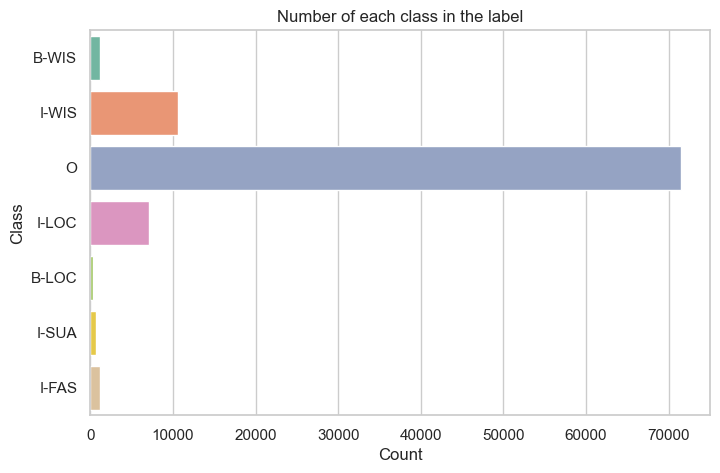

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt

# Contoh data frame, pastikan Anda sudah memilikinya
# train_df = ...

# Setel tata letak plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Plot countplot horizontal
ax = sns.countplot(y=train_df['Label'], palette="Set2")

plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Number of each class in the label")
plt.show()


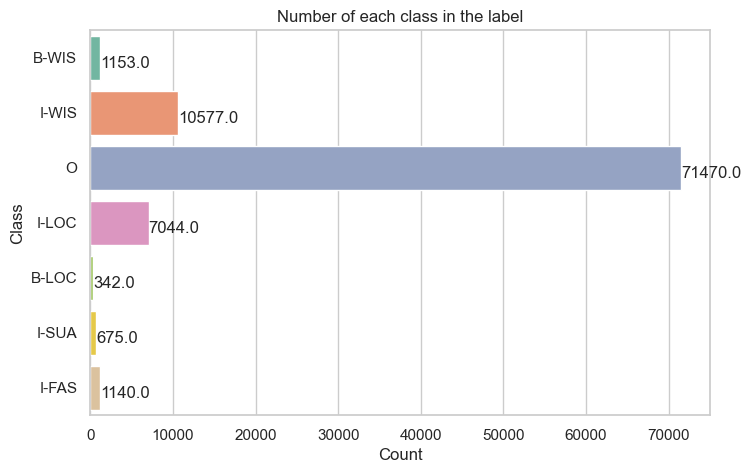

In [167]:
import seaborn as sns
import matplotlib.pyplot as plt

# Contoh data frame, pastikan Anda sudah memilikinya
# train_df = ...

# Setel tata letak plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Plot countplot horizontal
ax = sns.countplot(y=train_df['Label'], palette="Set2")

# Tambahkan teks jumlah di sebelah setiap bar
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_width() + 1, p.get_y() + 0.5), ha='left', va='center')

plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Number of each class in the label")
plt.show()


In [32]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.set(style="whitegrid")
# plt.figure(figsize=(8, 5))
# sns.countplot(y=test_df['Label'], palette="Set2")  # Gunakan 'y' untuk countplot horizontal
# plt.xlabel("Count")
# plt.ylabel("Category")
# plt.title("Jumlah kelas label pada data test")
# plt.show()

In [33]:
len(train_df['Label'])

92401

In [34]:
# len(test_df['Label'])

In [35]:
print(f"{train_df.shape}")
# print(f"{test_df.shape}")

(92401, 3)


In [36]:
sentences = train_df["Sentence Index"].values[-1] + 1

In [37]:
def get_dict_map(train_df, token_or_tag):
    tok2idx = {}
    idx2tok = {}

    if token_or_tag == 'token':
        vocab = [''] + list(set(train_df['Entitas'].to_list()))
    else:
        vocab = [''] + list(set(train_df['Label'].to_list()))

    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(train_df, 'token')
tag2idx, idx2tag = get_dict_map(train_df, 'tag')

In [38]:
def get_dict_map(train_df, token_or_tag):
    tok2idx = {}
    idx2tok = {}

    if token_or_tag == 'token':
        vocab = [''] + list(set(train_df['Entitas'].to_list()))
    else:
        vocab = [''] + list(set(train_df['Label'].to_list()))

    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(train_df, 'token')
lemma2idx, idx2lemma = get_dict_map(train_df, 'lemma')
pos2idx, idx2pos = get_dict_map(train_df, 'pos')
tag2idx, idx2tag = get_dict_map(train_df, 'tag')

In [39]:
tag2idx

{'': 0,
 'I-SUA': 1,
 'I-LOC': 2,
 'I-WIS': 3,
 'I-FAS': 4,
 'B-LOC': 5,
 'O': 6,
 'B-WIS': 7}

In [40]:
train_df

,Sentence Index,Entitas,Label
0,0,dinding,B-WIS
1,0,friwenm,I-WIS
2,0,keindahan,O
3,0,raja,I-LOC
4,0,ampat,I-LOC
...,...,...,...
100177,7203,senopati,I-LOC
100178,7203,jakarta,I-LOC
100179,7203,timur,I-LOC
100180,7203,kawasan,I-LOC


In [41]:
train_df['Entitas Index'] = train_df['Entitas'].map(token2idx)
train_df['Label Index'] = train_df['Label'].map(tag2idx)

In [42]:
train_df

,Sentence Index,Entitas,Label,Entitas Index,Label Index
0,0,dinding,B-WIS,1329,7
1,0,friwenm,I-WIS,2093,3
2,0,keindahan,O,4488,6
3,0,raja,I-LOC,2415,2
4,0,ampat,I-LOC,440,2
...,...,...,...,...,...
100177,7203,senopati,I-LOC,3244,2
100178,7203,jakarta,I-LOC,4494,2
100179,7203,timur,I-LOC,8006,2
100180,7203,kawasan,I-LOC,1113,2


In [48]:
# Fill na
df_fillna = train_df.fillna(method='ffill', axis=0)

# Groupby and collect columns
df_group = df_fillna.groupby(['Sentence Index'], as_index=False)[
    ['Entitas', 'Label', 'Entitas Index', 'Label Index']
].agg(lambda x: list(x))

# Visualise data
df_group.head()


,Sentence Index,Entitas,Label,Entitas Index,Label Index
0,0,"[dinding, friwenm, keindahan, raja, ampat, tak...","[B-WIS, I-WIS, O, I-LOC, I-LOC, O, O, I-WIS, I...","[1329, 2093, 4488, 2415, 440, 1710, 2070, 1844...","[7, 3, 6, 2, 2, 6, 6, 3, 3, 3, 3, 3]"
1,1,"[mengutip, situs, raja, ampat, geopark, raja, ...","[O, O, I-WIS, I-WIS, I-WIS, I-WIS, I-WIS, O, O...","[7287, 200, 2415, 440, 5930, 2415, 440, 965, 3...","[6, 6, 3, 3, 3, 3, 3, 6, 6, 6, 2, 6, 3, 3, 6, ..."
2,2,"[labuan, bajo, dikenal, surga, tersembunyi, in...","[B-LOC, I-LOC, O, O, O, I-LOC, I-LOC, I-LOC]","[1676, 1517, 5140, 6633, 6990, 1224, 1726, 8006]","[5, 2, 6, 6, 6, 2, 2, 2]"
3,3,"[desa, berada, kecamatan, komodo, kabupaten, m...","[B-LOC, O, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, ...","[1802, 7726, 870, 367, 2432, 3143, 2493, 4778,...","[5, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, ..."
4,4,"[mengutip, situs, kemlu, labuan, bajo, menjadi...","[O, O, O, I-LOC, I-LOC, O, O, O, O, O, O, O, O]","[7287, 200, 7998, 1676, 1517, 6640, 760, 6785,...","[6, 6, 6, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6]"


In [49]:
df_group.tail()

,Sentence Index,Entitas,Label,Entitas Index,Label Index
7199,7199,"[advertisement, kepala, bidang, destinasi, pen...","[O, O, O, O, O, O, O, B-LOC, I-LOC, O, O, O, O...","[7097, 507, 1486, 760, 1299, 4398, 519, 6762, ...","[6, 6, 6, 6, 6, 6, 6, 5, 2, 6, 6, 6, 6, 6, 6, ..."
7200,7200,"[tinggal, kemudian, pihaknya, mendorong, dinas...","[O, O, O, O, O, O, B-LOC, O, O, O]","[5721, 739, 3473, 4428, 3598, 4109, 6762, 6773...","[6, 6, 6, 6, 6, 6, 5, 6, 6, 6]"
7201,7201,"[kawasan, direkomendasikan, jakarta, utara, ka...","[O, O, B-LOC, O, O, O, O]","[1113, 560, 4494, 2038, 1113, 1176, 6414]","[6, 6, 5, 6, 6, 6, 6]"
7202,7202,"[kawsan, jakarta, barat, kawasan]","[O, B-LOC, O, O]","[5390, 4494, 2493, 1113]","[6, 5, 6, 6]"
7203,7203,"[kawasan, jakarta, pusat, cikini, jalan, medan...","[I-LOC, I-LOC, O, I-LOC, O, I-LOC, I-LOC, O, I...","[1113, 4494, 3087, 7753, 259, 1042, 3410, 6546...","[2, 2, 6, 2, 6, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, ..."


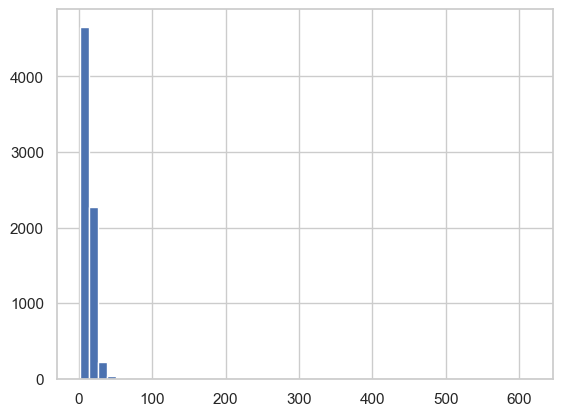

In [50]:
%matplotlib inline
plt.hist([len(s) for s in df_group['Entitas Index']], bins=50) # sentence length histogram
plt.show()

In [51]:
def get_pad_train_dev(df_group, train_df):

    #Pad tokens (X var)
    tokens = df_group['Entitas Index'].tolist()
    maxlen = max([len(s) for s in df_group['Entitas Index']])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', value= token2idx[""])

    #Pad Tags (y var) and convert it into one hot encoding
    tags = df_group['Label Index'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags_ = [to_categorical(i, num_classes=n_tags) for i in pad_tags]

    #Split train and dev set
    train_tokens, dev_tokens, train_tags, dev_tags = train_test_split(pad_tokens, pad_tags_, test_size = 0.25, train_size =0.85, random_state=1)

    print(
        'train_tokens length:', len(train_tokens),
        '\ndev_tokens length:', len(dev_tokens),
        '\ntrain_tags:', len(train_tags),
        '\ndev_tags:', len(dev_tags),
    )

    return np.array(train_tokens), np.array(dev_tokens), np.array(train_tags), np.array(dev_tags)

train_tokens_, dev_tokens_, train_tags_, dev_tags_ = get_pad_train_dev(df_group, train_df)

train_tokens length: 6483 
dev_tokens length: 721 
train_tags: 6483 
dev_tags: 721


This is how the data can be converted back to human-readable form.

In [52]:
[(idx2token[x], idx2tag[np.argmax(y)]) for x, y in zip(train_tokens_[641], train_tags_[641]) if idx2token[x]]

[('jakarta', 'B-LOC'),
 ('objek', 'O'),
 ('wisata', 'O'),
 ('indonesia', 'I-LOC'),
 ('tak', 'O'),
 ('terhingga', 'O'),
 ('jumlahnya', 'O')]

Neural Network Parameters

In [53]:
input_dim = len(list(set(train_df['Entitas'].to_list())))+1 # vocab length + padding
output_dim = 64
input_length = train_tokens_.shape[1] # max example length
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  8012 
output_dim:  64 
input_length:  616 
n_tags:  8


In [54]:
 # This takes ~2 mins.
 %time embeddings = fasttext.load_model('cc.id.300.bin')

CPU times: total: 2.62 s
Wall time: 1min 37s


In [55]:
# Prepare embedding matrix
hits = misses = 0 # in case of FastText all tokens should be covered
embedding_matrix = np.zeros((len(token2idx), embeddings.get_dimension()))
for word, i in token2idx.items():
    embedding_vector = embeddings[word]
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 8012 words (0 misses)


## Neural Network Architecture

We use BiLSTM & LSTM with dropouts. You can experiment with this. A larger network does not always bring better results.

For the output layer, we use softmax and categorical crossentropy loss - this is the most suitable setting for categorization tasks.

In the Embedding layer, we use the FastText weights as inputs.

Since the sequences are padded with zeros, it is extremely easy for the net to learn these paddings. On the other hand, this information is not useful in the evaluation. For this reason, we use the masking of zeros, so they do not contribute to the evaluation calculation. (If you switch ``mask_zero`` to ``False``, your net will have 99% accuracy without being better than a masked net.

In [104]:
tag2idx

{'': 0,
 'I-SUA': 1,
 'I-LOC': 2,
 'I-WIS': 3,
 'I-FAS': 4,
 'B-LOC': 5,
 'O': 6,
 'B-WIS': 7}

In [119]:
input_length

616

In [83]:
model1 = Sequential()

# Add Embedding layer
model1.add(Embedding(input_dim=input_dim, output_dim=embeddings.get_dimension(), input_length=input_length, embeddings_initializer=Constant(embedding_matrix), trainable=True, mask_zero=True))
#model1.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, trainable=True, mask_zero=True))

model1.add(Dropout(0.5))
# Add BiLSTM
model1.add(Bidirectional(LSTM(units=input_dim*2, return_sequences=True), merge_mode = 'concat'))

model1.add(Dropout(0.5))
model1.add(LSTM(units=input_dim, return_sequences=True))

# Add timeDistributed Layer
model1.add(TimeDistributed(Dense(n_tags, activation="softmax")))

#Optimiser
adam = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

# Compile model1
hist = model1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#model1.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 616, 300)          2403600   
                                                                 
 dropout_17 (Dropout)        (None, 616, 300)          0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 616, 256)         439296    
 onal)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 616, 256)          0         
                                                                 
 lstm_15 (LSTM)              (None, 616, 64)           82176     
                                                                 
 time_distributed_10 (TimeDi  (None, 616, 8)           520       
 stributed)                                          

In [84]:
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

True

In [85]:
len(train_tokens_)

6483

In [86]:
# Training: It takes several minutes.
hist1 = model1.fit(train_tokens_, train_tags_, batch_size=16, verbose=1, epochs=5, validation_data=(dev_tokens_, dev_tags_))

Epoch 1/5
325/325 [==============================] - 1643s 5s/step - loss: 0.0078 - accuracy: 0.8871 - val_loss: 0.0047 - val_accuracy: 0.9305
Epoch 2/5
325/325 [==============================] - 1497s 5s/step - loss: 0.0038 - accuracy: 0.9419 - val_loss: 0.0040 - val_accuracy: 0.9363
Epoch 3/5
325/325 [==============================] - 1528s 5s/step - loss: 0.0030 - accuracy: 0.9533 - val_loss: 0.0039 - val_accuracy: 0.9406
Epoch 4/5
325/325 [==============================] - 1492s 5s/step - loss: 0.0026 - accuracy: 0.9573 - val_loss: 0.0040 - val_accuracy: 0.9392
Epoch 5/5
325/325 [==============================] - 1490s 5s/step - loss: 0.0024 - accuracy: 0.9605 - val_loss: 0.0039 - val_accuracy: 0.9407


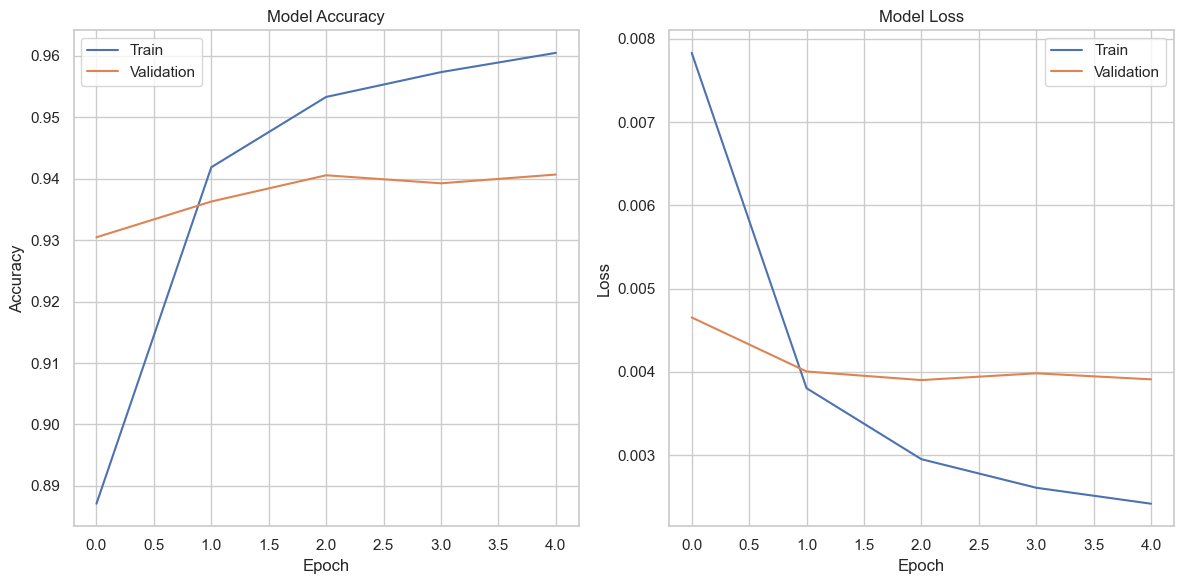

In [136]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(hist1.history['accuracy'], label='Train')
plt.plot(hist1.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist1.history['loss'], label='Train')
plt.plot(hist1.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

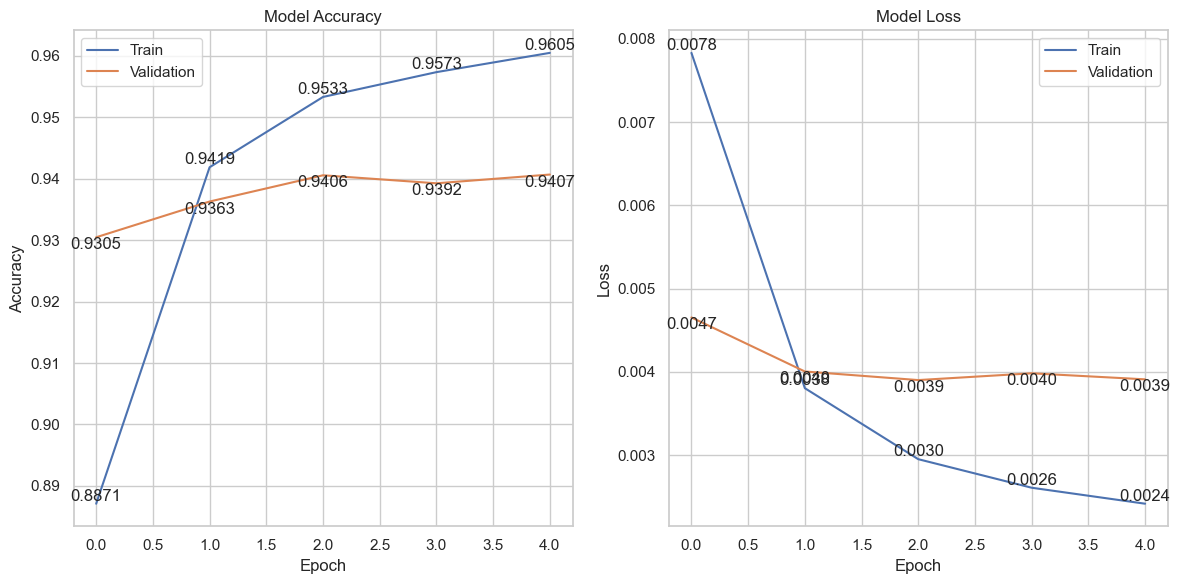

In [162]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(hist1.history['accuracy'], label='Train')
plt.plot(hist1.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Tambahkan keterangan angka pada tiap epoch kelipatan 10
for i in range(0, len(hist1.history['accuracy']), 1):
    plt.text(i, hist1.history['accuracy'][i], '{:.4f}'.format(hist1.history['accuracy'][i]), ha='center', va='bottom')

for i in range(0, len(hist1.history['val_accuracy']), 1):
    plt.text(i, hist1.history['val_accuracy'][i], '{:.4f}'.format(hist1.history['val_accuracy'][i]), ha='center', va='top')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist1.history['loss'], label='Train')
plt.plot(hist1.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Tambahkan keterangan angka pada tiap epoch kelipatan 1
for i in range(0, len(hist1.history['loss']), 1):
    plt.text(i, hist1.history['loss'][i], '{:.4f}'.format(hist1.history['loss'][i]), ha='center', va='bottom')

for i in range(0, len(hist1.history['val_loss']), 1):
    plt.text(i, hist1.history['val_loss'][i], '{:.4f}'.format(hist1.history['val_loss'][i]), ha='center', va='top')

plt.tight_layout()
plt.show()


In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(hist1.history['accuracy'], label='Train')
plt.plot(hist1.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Tambahkan keterangan angka pada tiap epoch
for i, acc in enumerate(hist1.history['accuracy']):
    plt.text(i, acc, f'{acc:.4f}', ha='center', va='bottom')

for i, val_acc in enumerate(hist1.history['val_accuracy']):
    plt.text(i, val_acc, f'{val_acc:.4f}', ha='center', va='top')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist1.history['loss'], label='Train')
plt.plot(hist1.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Tambahkan keterangan angka pada tiap epoch
for i, loss in enumerate(hist1.history['loss']):
    plt.text(i, loss, f'{loss:.4f}', ha='center', va='bottom')

for i, val_loss in enumerate(hist1.history['val_loss']):
    plt.text(i, val_loss, f'{val_loss:.4f}', ha='center', va='top')

plt.tight_layout()
plt.show()


In [147]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant

# Assuming you have defined input_dim, embeddings, input_length, output_dim, n_tags, and embedding_matrix

model2 = Sequential()

# Add Embedding layer
model2.add(Embedding(input_dim=input_dim, output_dim=embeddings.get_dimension(), input_length=input_length, embeddings_initializer=Constant(embedding_matrix), trainable=True, mask_zero=False))
model2.add(Dropout(0.5))

# Add 1D CNN layer with dropout
model2.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model2.add(Dropout(0.5))

# Add Bidirectional LSTM with dropout and L2 regularization
model2.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)), merge_mode='concat'))
model2.add(Dropout(0.5))

# TimeDistributed Layer with Dense for sequence tagging
model2.add(TimeDistributed(Dense(n_tags, activation="softmax")))

# Optimizer
adam = Adam(learning_rate=0.001)

# Compile model
model2.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


In [148]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Assuming you have a fit statement like this
hist2 = model2.fit(train_tokens_, train_tags_, epochs=100, batch_size=32, validation_data=(dev_tokens_, dev_tags_))

Epoch 1/100
203/203 [==============================] - 27s 112ms/step - loss: 0.7423 - accuracy: 0.9902 - val_loss: 0.0746 - val_accuracy: 0.9954
Epoch 2/100
203/203 [==============================] - 23s 112ms/step - loss: 0.0368 - accuracy: 0.9956 - val_loss: 0.0188 - val_accuracy: 0.9960
Epoch 3/100
203/203 [==============================] - 21s 105ms/step - loss: 0.0158 - accuracy: 0.9960 - val_loss: 0.0130 - val_accuracy: 0.9963
Epoch 4/100
203/203 [==============================] - 20s 101ms/step - loss: 0.0126 - accuracy: 0.9963 - val_loss: 0.0114 - val_accuracy: 0.9965
Epoch 5/100
203/203 [==============================] - 20s 100ms/step - loss: 0.0113 - accuracy: 0.9965 - val_loss: 0.0104 - val_accuracy: 0.9969
Epoch 6/100
203/203 [==============================] - 20s 99ms/step - loss: 0.0104 - accuracy: 0.9967 - val_loss: 0.0098 - val_accuracy: 0.9970
Epoch 7/100
203/203 [==============================] - 20s 98ms/step - loss: 0.0098 - accuracy: 0.9969 - val_loss: 0.0093 - v

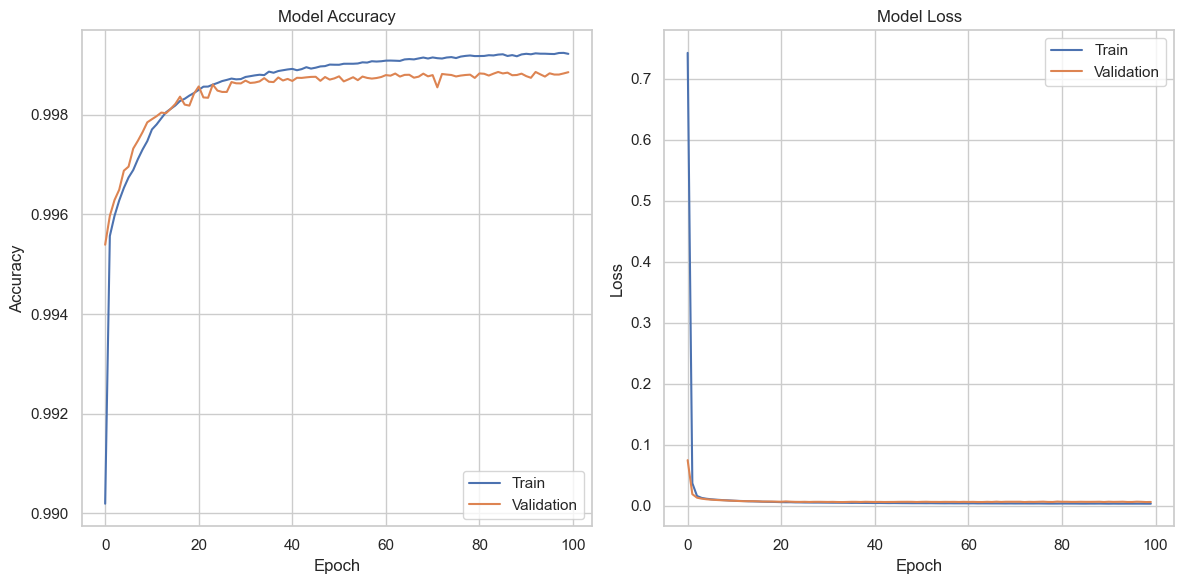

In [149]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(hist2.history['accuracy'], label='Train')
plt.plot(hist2.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist2.history['loss'], label='Train')
plt.plot(hist2.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [151]:
hist2

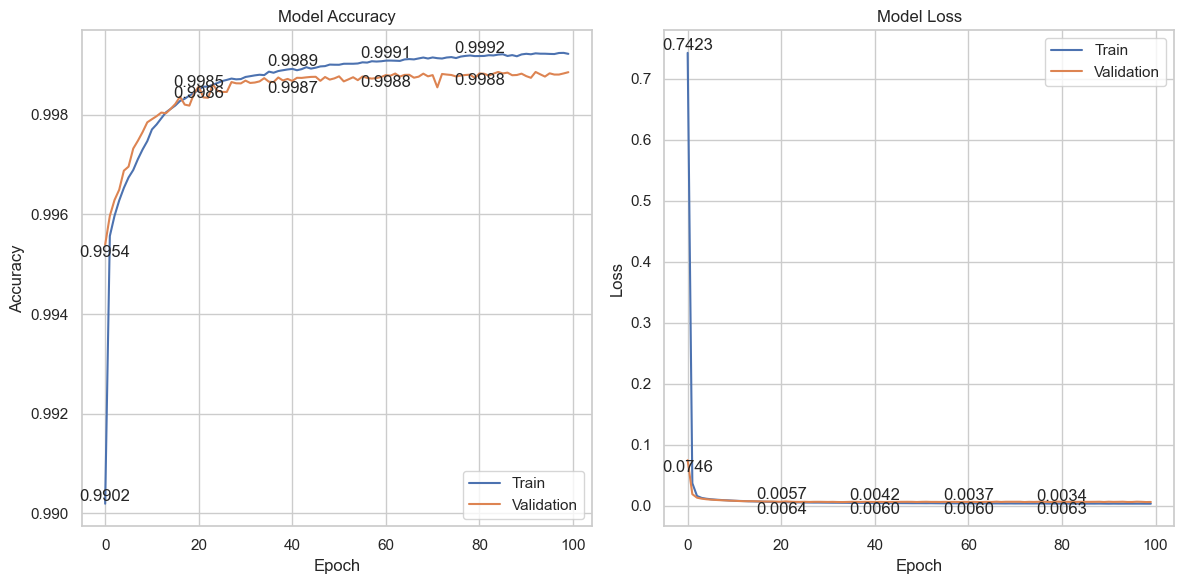

In [160]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(hist2.history['accuracy'], label='Train')
plt.plot(hist2.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Tambahkan keterangan angka pada tiap epoch kelipatan 10
for i in range(0, len(hist2.history['accuracy']), 20):
    plt.text(i, hist2.history['accuracy'][i], '{:.4f}'.format(hist2.history['accuracy'][i]), ha='center', va='bottom')

for i in range(0, len(hist2.history['val_accuracy']), 20):
    plt.text(i, hist2.history['val_accuracy'][i], '{:.4f}'.format(hist2.history['val_accuracy'][i]), ha='center', va='top')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist2.history['loss'], label='Train')
plt.plot(hist2.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Tambahkan keterangan angka pada tiap epoch kelipatan 20
for i in range(0, len(hist2.history['loss']), 20):
    plt.text(i, hist2.history['loss'][i], '{:.4f}'.format(hist2.history['loss'][i]), ha='center', va='bottom')

for i in range(0, len(hist2.history['val_loss']), 20):
    plt.text(i, hist2.history['val_loss'][i], '{:.4f}'.format(hist2.history['val_loss'][i]), ha='center', va='top')

plt.tight_layout()
plt.show()


## Sample predictions on the train set

Below, you can see predictions on the train set. Not surprisingly, they are correct.

**TASK 2** Modify the code to display dev set predictions. Comment on what you see.

**OPTIONAL TASK** Evaluate the network on the dev set. What entities are easy to recognize? Which are hard?

In [89]:
i = 0

#[(idx2token[x], idx2tag[np.argmax(y)]) for x, y in zip(train_tokens_[103], train_tags_[103]) if idx2token[x]]

for sample, annotation in zip(train_tokens_, train_tags_):
  ex=sample.reshape((1, sample.shape[0]))
  prediction = model1.predict(ex)
  ner = np.squeeze(np.argmax(prediction, axis=-1)[:len(sample)])
  print([(idx2token[x], idx2tag[np.argmax(y)], idx2tag[z]) for x, y, z in zip(sample, annotation, ner) if idx2token[x]])
  i += 1
  if i == 10:
    break

1/1 [==============================] - 6s 6s/step
[('adapun', 'O', 'O'), ('tujuannya', 'O', 'O'), ('mengoptimalisasi', 'O', 'O'), ('berbagai', 'O', 'O'), ('potensi', 'O', 'O'), ('menggerakan', 'O', 'O'), ('roda', 'O', 'O'), ('perekonomian', 'O', 'O'), ('indonesia', 'I-LOC', 'I-LOC')]
1/1 [==============================] - 1s 582ms/step
[('sejalan', 'O', 'O'), ('dorongan', 'O', 'O'), ('pemerintah', 'O', 'O'), ('lewat', 'O', 'O'), ('gerakan', 'O', 'O'), ('nasional', 'O', 'O'), ('bangga', 'O', 'O'), ('buatan', 'O', 'O'), ('indonesia', 'I-LOC', 'I-LOC'), ('gernas', 'O', 'O'), ('bbi', 'O', 'O')]
1/1 [==============================] - 1s 581ms/step
[('dufan', 'B-WIS', 'B-WIS'), ('sendiri', 'O', 'O'), ('dikenal', 'O', 'O'), ('salah', 'O', 'O'), ('satu', 'O', 'O'), ('pusat', 'O', 'O'), ('rekreasi', 'O', 'O'), ('hiburan', 'O', 'O'), ('terbesar', 'O', 'O'), ('indonesia', 'I-LOC', 'I-LOC'), ('menyediakan', 'O', 'O'), ('kawasan', 'O', 'O'), ('konsep', 'O', 'O'), ('fantasi', 'O', 'O'), ('menakjubka

In [90]:
i = 0

#[(idx2token[x], idx2tag[np.argmax(y)]) for x, y in zip(train_tokens_[103], train_tags_[103]) if idx2token[x]]

for sample, annotation in zip(dev_tokens_, dev_tags_):
  ex=sample.reshape((1, sample.shape[0]))
  prediction = model1.predict(ex)
  ner = np.squeeze(np.argmax(prediction, axis=-1)[:len(sample)])
  print([(idx2token[x], idx2tag[np.argmax(y)], idx2tag[z]) for x, y, z in zip(sample, annotation, ner) if idx2token[x]])
  i += 1
  if i == 10:
    break

1/1 [==============================] - 1s 654ms/step
[('merdeka', 'B-WIS', 'B-WIS'), ('walk', 'I-WIS', 'I-WIS'), ('dikenal', 'O', 'O'), ('pusat', 'O', 'O'), ('kuliner', 'O', 'O'), ('objek', 'O', 'O'), ('wisata', 'O', 'O'), ('medan', 'I-LOC', 'I-LOC')]
1/1 [==============================] - 1s 676ms/step
[('urusan', 'O', 'O'), ('akomodasi', 'O', 'O'), ('jauh', 'O', 'O'), ('tempat', 'O', 'O'), ('wisata', 'O', 'O'), ('beberapa', 'O', 'O'), ('hotel', 'I-FAS', 'I-FAS'), ('penginapan', 'I-FAS', 'I-FAS'), ('singgahi', 'O', 'I-FAS')]
1/1 [==============================] - 1s 659ms/step
[('rumah', 'I-FAS', 'O'), ('besar', 'O', 'O'), ('memiliki', 'O', 'O'), ('ukuran', 'O', 'O'), ('sebesar', 'O', 'O'), ('8000', 'O', 'O'), ('mÂ²', 'O', 'O'), ('dalamnya', 'O', 'O'), ('terbagi', 'O', 'O'), ('35', 'O', 'O'), ('ruangan', 'O', 'O'), ('kamu', 'O', 'O'), ('telusuri', 'O', 'O'), ('berkunjung', 'O', 'O')]
1/1 [==============================] - 1s 800ms/step
[('kawasan', 'O', 'O'), ('terkenal', 'O', 'O'), (

## Test dengan data baru

In [95]:
my_sentence = "Keindahan Indonesia memiliki banyak gunung indah dan banyak spot foto Indonesia"
encoded = [token2idx.get(t, 0) for t in my_sentence.split()] + [0] * input_length
print("OOV:", [t for t in my_sentence.split() if t not in token2idx])
encoded = encoded[:input_length]

sample = np.array(encoded).reshape((1, input_length))
prediction = model1.predict(sample)
ner = np.squeeze(np.argmax(prediction, axis=-1)[:len(my_sentence.split())])
print([(t, idx2tag[n]) for t, n in zip(my_sentence.split(), ner)])

OOV: ['Keindahan', 'Indonesia', 'Indonesia']
1/1 [==============================] - 1s 619ms/step
[('Keindahan', 'O'), ('Indonesia', 'O'), ('memiliki', 'O'), ('banyak', 'O'), ('gunung', 'I-WIS'), ('indah', 'I-SUA'), ('dan', 'O'), ('banyak', 'O'), ('spot', 'I-FAS'), ('foto', 'I-FAS'), ('Indonesia', 'I-FAS')]


In [96]:
i = 0

#[(idx2token[x], idx2tag[np.argmax(y)]) for x, y in zip(train_tokens_[103], train_tags_[103]) if idx2token[x]]

for sample, annotation in zip(train_tokens_, train_tags_):
  ex=sample.reshape((1, sample.shape[0]))
  prediction = model2.predict(ex)
  ner = np.squeeze(np.argmax(prediction, axis=-1)[:len(sample)])
  print([(idx2token[x], idx2tag[np.argmax(y)], idx2tag[z]) for x, y, z in zip(sample, annotation, ner) if idx2token[x]])
  i += 1
  if i == 10:
    break

1/1 [==============================] - 1s 1s/step
[('adapun', 'O', 'O'), ('tujuannya', 'O', 'O'), ('mengoptimalisasi', 'O', 'O'), ('berbagai', 'O', 'O'), ('potensi', 'O', 'O'), ('menggerakan', 'O', 'O'), ('roda', 'O', 'O'), ('perekonomian', 'O', 'O'), ('indonesia', 'I-LOC', 'I-LOC')]
1/1 [==============================] - 0s 63ms/step
[('sejalan', 'O', 'O'), ('dorongan', 'O', 'O'), ('pemerintah', 'O', 'O'), ('lewat', 'O', 'O'), ('gerakan', 'O', 'O'), ('nasional', 'O', 'O'), ('bangga', 'O', 'O'), ('buatan', 'O', 'O'), ('indonesia', 'I-LOC', 'I-LOC'), ('gernas', 'O', 'O'), ('bbi', 'O', 'O')]
1/1 [==============================] - 0s 86ms/step
[('dufan', 'B-WIS', 'B-WIS'), ('sendiri', 'O', 'O'), ('dikenal', 'O', 'O'), ('salah', 'O', 'O'), ('satu', 'O', 'O'), ('pusat', 'O', 'O'), ('rekreasi', 'O', 'O'), ('hiburan', 'O', 'O'), ('terbesar', 'O', 'O'), ('indonesia', 'I-LOC', 'I-LOC'), ('menyediakan', 'O', 'O'), ('kawasan', 'O', 'O'), ('konsep', 'O', 'O'), ('fantasi', 'O', 'O'), ('menakjubkan'

In [98]:
i = 0

#[(idx2token[x], idx2tag[np.argmax(y)]) for x, y in zip(train_tokens_[103], train_tags_[103]) if idx2token[x]]

for sample, annotation in zip(dev_tokens_, dev_tags_):
  ex=sample.reshape((1, sample.shape[0]))
  prediction = model2.predict(ex)
  ner = np.squeeze(np.argmax(prediction, axis=-1)[:len(sample)])
  print([(idx2token[x], idx2tag[np.argmax(y)], idx2tag[z]) for x, y, z in zip(sample, annotation, ner) if idx2token[x]])
  i += 1
  if i == 10:
    break

1/1 [==============================] - 0s 66ms/step
[('merdeka', 'B-WIS', 'B-WIS'), ('walk', 'I-WIS', 'I-WIS'), ('dikenal', 'O', 'O'), ('pusat', 'O', 'O'), ('kuliner', 'O', 'O'), ('objek', 'O', 'O'), ('wisata', 'O', 'O'), ('medan', 'I-LOC', 'I-LOC')]
1/1 [==============================] - 0s 59ms/step
[('urusan', 'O', 'O'), ('akomodasi', 'O', 'O'), ('jauh', 'O', 'O'), ('tempat', 'O', 'O'), ('wisata', 'O', 'O'), ('beberapa', 'O', 'O'), ('hotel', 'I-FAS', 'I-FAS'), ('penginapan', 'I-FAS', 'O'), ('singgahi', 'O', 'O')]
1/1 [==============================] - 0s 58ms/step
[('rumah', 'I-FAS', 'O'), ('besar', 'O', 'O'), ('memiliki', 'O', 'O'), ('ukuran', 'O', 'O'), ('sebesar', 'O', 'O'), ('8000', 'O', 'O'), ('mÂ²', 'O', 'O'), ('dalamnya', 'O', 'O'), ('terbagi', 'O', 'O'), ('35', 'O', 'O'), ('ruangan', 'O', 'O'), ('kamu', 'O', 'O'), ('telusuri', 'O', 'O'), ('berkunjung', 'O', 'O')]
1/1 [==============================] - 0s 51ms/step
[('kawasan', 'O', 'O'), ('terkenal', 'O', 'O'), ('objek', 'O'

In [135]:
my_sentence = "Tempat wisata di eropa jakarta surabaya labuhan bajo amerika surakarta yogyakarta sangat mirip dengan ancol"
encoded = [token2idx.get(t, 0) for t in my_sentence.split()] + [0] * input_length
print("OOV:", [t for t in my_sentence.split() if t not in token2idx])
encoded = encoded[:input_length]

sample = np.array(encoded).reshape((1, input_length))
prediction = model1.predict(sample)
ner = np.squeeze(np.argmax(prediction, axis=-1)[:len(my_sentence.split())])
print([(t, idx2tag[n]) for t, n in zip(my_sentence.split(), ner)])

OOV: ['Tempat']
1/1 [==============================] - 1s 565ms/step
[('Tempat', 'O'), ('wisata', 'O'), ('di', 'O'), ('eropa', 'I-LOC'), ('jakarta', 'I-LOC'), ('surabaya', 'I-LOC'), ('labuhan', 'I-LOC'), ('bajo', 'I-LOC'), ('amerika', 'I-LOC'), ('surakarta', 'I-LOC'), ('yogyakarta', 'I-LOC'), ('sangat', 'O'), ('mirip', 'O'), ('dengan', 'O'), ('ancol', 'I-WIS')]


In [168]:
my_sentence = "Sungai maron sangat sejuk di pacitan"
encoded = [token2idx.get(t, 0) for t in my_sentence.split()] + [0] * input_length
print("OOV:", [t for t in my_sentence.split() if t not in token2idx])
encoded = encoded[:input_length]

sample = np.array(encoded).reshape((1, input_length))
prediction = model1.predict(sample)
ner = np.squeeze(np.argmax(prediction, axis=-1)[:len(my_sentence.split())])
print([(t, idx2tag[n]) for t, n in zip(my_sentence.split(), ner)])

OOV: ['Sungai']
1/1 [==============================] - 1s 856ms/step
[('Sungai', 'O'), ('maron', 'B-WIS'), ('sangat', 'O'), ('sejuk', 'I-SUA'), ('di', 'O'), ('pacitan', 'I-LOC')]


In [169]:
my_sentence = "Sungai maron sangat sejuk di pacitan"
encoded = [token2idx.get(t, 0) for t in my_sentence.split()] + [0] * input_length
print("OOV:", [t for t in my_sentence.split() if t not in token2idx])
encoded = encoded[:input_length]

sample = np.array(encoded).reshape((1, input_length))
prediction = model2.predict(sample)
ner = np.squeeze(np.argmax(prediction, axis=-1)[:len(my_sentence.split())])
print([(t, idx2tag[n]) for t, n in zip(my_sentence.split(), ner)])

OOV: ['Sungai']
1/1 [==============================] - 2s 2s/step
[('Sungai', 'O'), ('maron', 'I-WIS'), ('sangat', 'O'), ('sejuk', 'O'), ('di', 'O'), ('pacitan', 'I-LOC')]
